In [2]:
VAR = 'Psi'  # Pick what plot
Full = 'N'  # 9 Pannels isn't ideal for presentations N option give 4 plots
Year = 'PSI.nc'
# Load in Modules
from scipy.io import netcdf
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import sys
import glob
from scipy.interpolate import interp1d
from scipy import interpolate
from numba import autojit
from pylab import *
from matplotlib import gridspec
sys.path.append('/noc/users/hb1g13/Python/python_functions/')
import useful as hb
import SG
%matplotlib inline
if Full == 'N':
    tau = ['3','300','3000','Closed']
    # tau = ['3000']
else:
    tau = ['3', '10', '30', '100', '300',
           '1000', '3000', '10000', 'Closed']
Figletter = ['a) ','b) ','c) ','d) ']
# x = '/hpcdata/scratch/hb1g13/NchannelFlat'
x='/noc/msm/scratch/students/hb1g13/Mobilis'


# Define a class that forces representation of float to look a certain way
# This remove trailing zero so '1.0' becomes '1'
class nf(float):
    def __repr__(self):
        str = '%.1f' % (self.__float__(),)
        if str[-1] == '0':
            return '%.0f' % self.__float__()
        else:
            return '%.1f' % self.__float__()
# Label levels with specially formatted floats
if plt.rcParams["text.usetex"]:
    fmt = r'%r $^oC$ %'
else:
    fmt = '%r $^oC$'
# Now Make file structure
check = 0
runs = []
for i in range(len(tau)):
    flist = x+'/'+str(tau[i])+'daynokpp/'+Year
    if not os.path.exists(flist):
        print ' WARNING: '+flist+' does not exist! (skipping this tau...)'
        check += 0
    else:
        check += 1
        runs.append(i)


# Make Some useful functions
def find_nearest(array, value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]


def regrid(Variable):
    Vc = (Variable[:, 0:-1]+Variable[:, 1::])/2
    return Vc
numba_regrid = autojit()(regrid)
numba_regrid.func_name = "numba_regrid"
Runs = np.array(runs)
# Set Parameters
alpha = 2.000000E-04
g = -9.81
rho_0 = 1000
C_p = 3985
gridfilepath = x+'/3daynokpp/'
file2 = netCDF4.Dataset(gridfilepath+'grid.nc', 'r')
Zp = file2.variables['Zp1'][:]
Z = file2.variables['Z'][:]
Y = file2.variables['Yp1'][:]
Yc = file2.variables['Y'][:]
dyc = file2.variables['dyC'][:]
dzc = file2.variables['drC'][:]
Zmatrix = np.zeros((len(Z), len(Yc)))
Zmatrix[:, :] = 1
dx = Y[1]-Y[0]  # Find Resolution
dz = Zp[0:len(Zp)-1]-Zp[1:len(Zp)]
Zmatrix[:,:] = np.apply_along_axis(np.multiply, 0, Zmatrix, dz)
DZ = np.apply_along_axis(np.multiply, 0, np.ones((len(Z),len(Yc))), Z)
ny = len(Y)
nz = len(Z)
Ly = 2000e3
Lx = 1000e3
H = Z[-1]
nx = np.round(Lx/dx)
ny = np.round(Ly/dx)
Q_0 = 10
Q = np.zeros_like(Yc)
pi = math.pi
Q = np.zeros(np.shape(Q))
Q[0:int(5*ny/36)] = Q_0*(np.cos(Yc[0:int(5*ny/36)]*(pi/(Yc[int(10*ny/36)]))))
Q[int(5*ny/36):int(20*ny/36)] = -Q_0*(np.sin((Yc[int(5*ny/36):int(20*ny/36)]-Yc[int(5*ny/36)])*(pi/(Yc[int(15*ny/36)]))))
Q[int(20*ny/36):int(30*ny/36)] = Q_0*(np.sin(Yc[0:int(10*ny/36)]*(pi/(Yc[int(10*ny/36)]))))
Psipred = -(Q)/(rho_0*C_p)
tRef = [7.95797596, 7.81253554, 7.50931741, 6.93595077, 6.23538398,
        5.60148493, 5.02790935, 4.5089167 , 4.03931274, 3.6143975 ,
        3.22991829, 2.88202712, 2.56724216, 2.28241296, 2.02468884,
        1.79149041, 1.58048375, 1.38955702, 1.21679938, 1.0604818 ,
        0.9190398 , 0.79105779, 0.67525488, 0.57047207, 0.47566066,
        0.38987176, 0.31224674, 0.24200873, 0.14898305, 0.04478574]

In [3]:
def ddy_cgrid_centered(y):
    dy = np.zeros(y.shape, np.float) #we know it will be this size
    h = Y[1] - Y[0] #this assumes the points are evenely spaced!
    dy[:,2:-2] = (y[:,0:-4] - 8 * y[:,1:-3] + 8 * y[:,3:-1] - y[:,4:]) / (12.0 * h)

    # simple differences at the end-points
    dy[:,0] = (y[:,1] - y[:,0])/(Y[1] - Y[0])
    dy[:,1] = (y[:,2] - y[:,1])/(Y[2] - Y[1])
    dy[:,-2] = (y[:,-2] - y[:,-3]) / (Y[-2] - Y[-3])
    dy[:,-1] = (y[:,-1] - y[:,-2]) / (Y[-1] - Y[-2])
    return dy

def ddz_cgrid_centered(y):
    dy = np.zeros(y.shape, np.float) 
    dy[0] = (y[0] - y[1])/(Z[0] - Z[1])
    for i in range(1,len(y)-1):
        dy[i] = (y[i+1] - y[i-1])/(Z[i+1]-Z[i-1])
    dy[-1] = (y[-1] - y[-2])/(Z[-1] - Z[-2])
    return dy

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def get_psi_iso_z(PSISO, Th):
    """Put the output from psi_iso into Z coordinates."""

    psi_iso = PSISO
    # figure out the depth of each layer
    h = Th
    # psi_iso is defined at the *bottom* of each layer,
    # therefore we want the depth at the bottom of the layer
    z = cumsum(h, axis=0) - (sum(th,axis=0))
    # interpolate to center z points
    psi_iso_z = zeros((nz+1,ny+1))
    for j in arange(ny):
        psi_iso_z[:,j] = interp(Zp[:],z[:,j], psi_iso[:,j])
    return psi_iso_z

\begin{equation}
\overline{v}\frac{\partial \overline{T}}{\partial y} + \overline{w}\frac{\partial \overline{T}}{\partial z} + \frac{\partial \overline{v'T'}}{\partial y} + \frac{\partial \overline{w'T'}}{\partial z}  = Q + Diff
\end{equation}

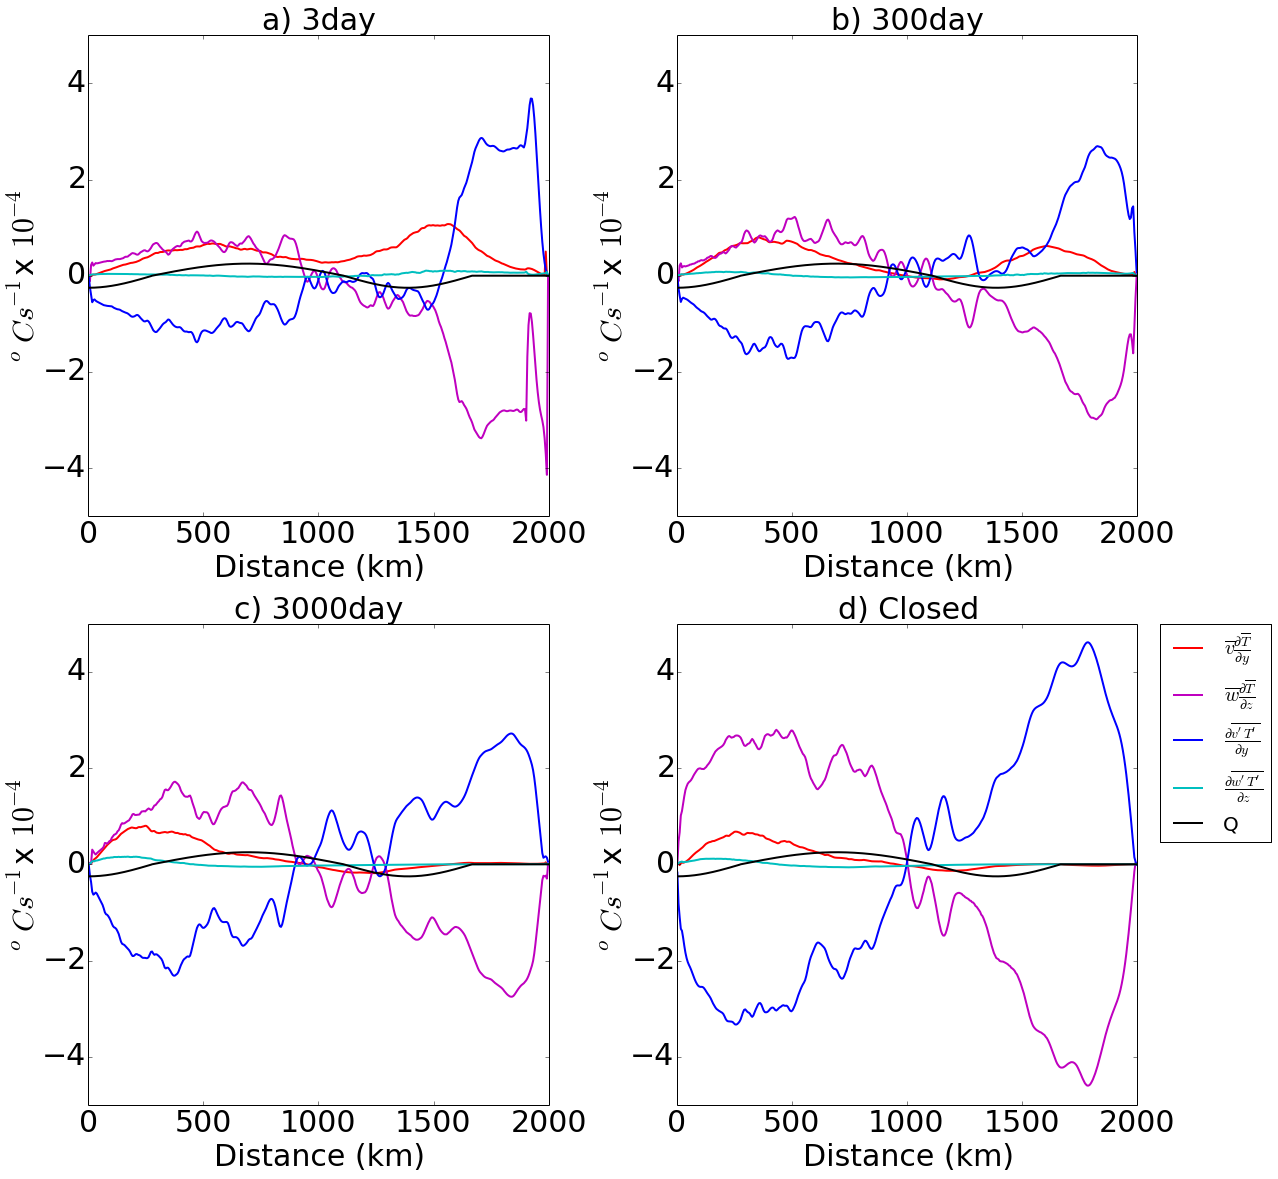

In [4]:
fig = plt.figure(figsize=(16.5, 16.5))
for i in range(len(Runs)):
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/TAV.nc'
    file2 = netCDF4.Dataset(fname, 'r')
    TTav = file2.variables['THETA'][:].mean(axis=0).mean(axis=2)
    VTav = file2.variables['VVEL'][:].mean(axis=0).mean(axis=2)
    WTav = file2.variables['WVEL'][:].mean(axis=0).mean(axis=2)
    npad =((0,1),(0,0))
    WTav = np.pad(WTav,pad_width=npad, mode='constant', constant_values=0)
    ax = fig.add_subplot(2, 2, i+1)
    Eddy1 = x+'/'+str(tau[Runs[i]])+'daynokpp/TAV_VT.nc'
    f2 = netCDF4.Dataset(Eddy1,'r')
    VTTav = f2.variables['VVELTH'][:].mean(axis=0).mean(axis=2)
    WTTav = f2.variables['WVELTH'][:].mean(axis=0).mean(axis=2)
    WTTav = np.pad(WTTav,pad_width=npad, mode='constant', constant_values=0)
    VpTp = hb.numba_regridy(VTTav) - hb.numba_regridy(VTav)*TTav
    WpTp = hb.numba_regridz(WTTav) - hb.numba_regridz(WTav)*TTav
    Ty = ddy_cgrid_centered(TTav)
    Tz = ddz_cgrid_centered(TTav)
    VTy = nansum(hb.numba_regridy(VTav)*Ty*Zmatrix,axis=0)
    WTz = nansum(hb.numba_regridz(WTav)*Tz*Zmatrix,axis=0)
    WpTpz = nansum(ddz_cgrid_centered(WpTp)*Zmatrix,axis = 0)
    VpTpy = nansum(ddy_cgrid_centered(VpTp)*Zmatrix,axis = 0)
    p = plt.plot(Yc/1000,VTy*10**5,'r',linewidth=2)
    p = plt.plot(Yc/1000,WTz*10**5,'m',linewidth=2)
    p = plt.plot(Yc/1000,VpTpy*10**5,'b',linewidth=2)
    p = plt.plot(Yc/1000,WpTpz*10**5,'c',linewidth=2)
    p = plt.plot(Yc/1000,Psipred*10**5,'k',linewidth=2)
    plt.ylim(-5,5)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel(r'$^oCs^{-1}$x $10^{-4}$', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
lgd=plt.legend([r'$\overline{v}\frac{\partial \overline{T}}{\partial y}$',r'$\overline{w}\frac{\partial \overline{T}}{\partial z}$',r'$\frac{\partial \overline{v^\prime T^\prime}}{\partial y}$',r'$\frac{\partial \overline{w^\prime T^\prime}}{\partial z}$','Q'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)
plt.tight_layout()

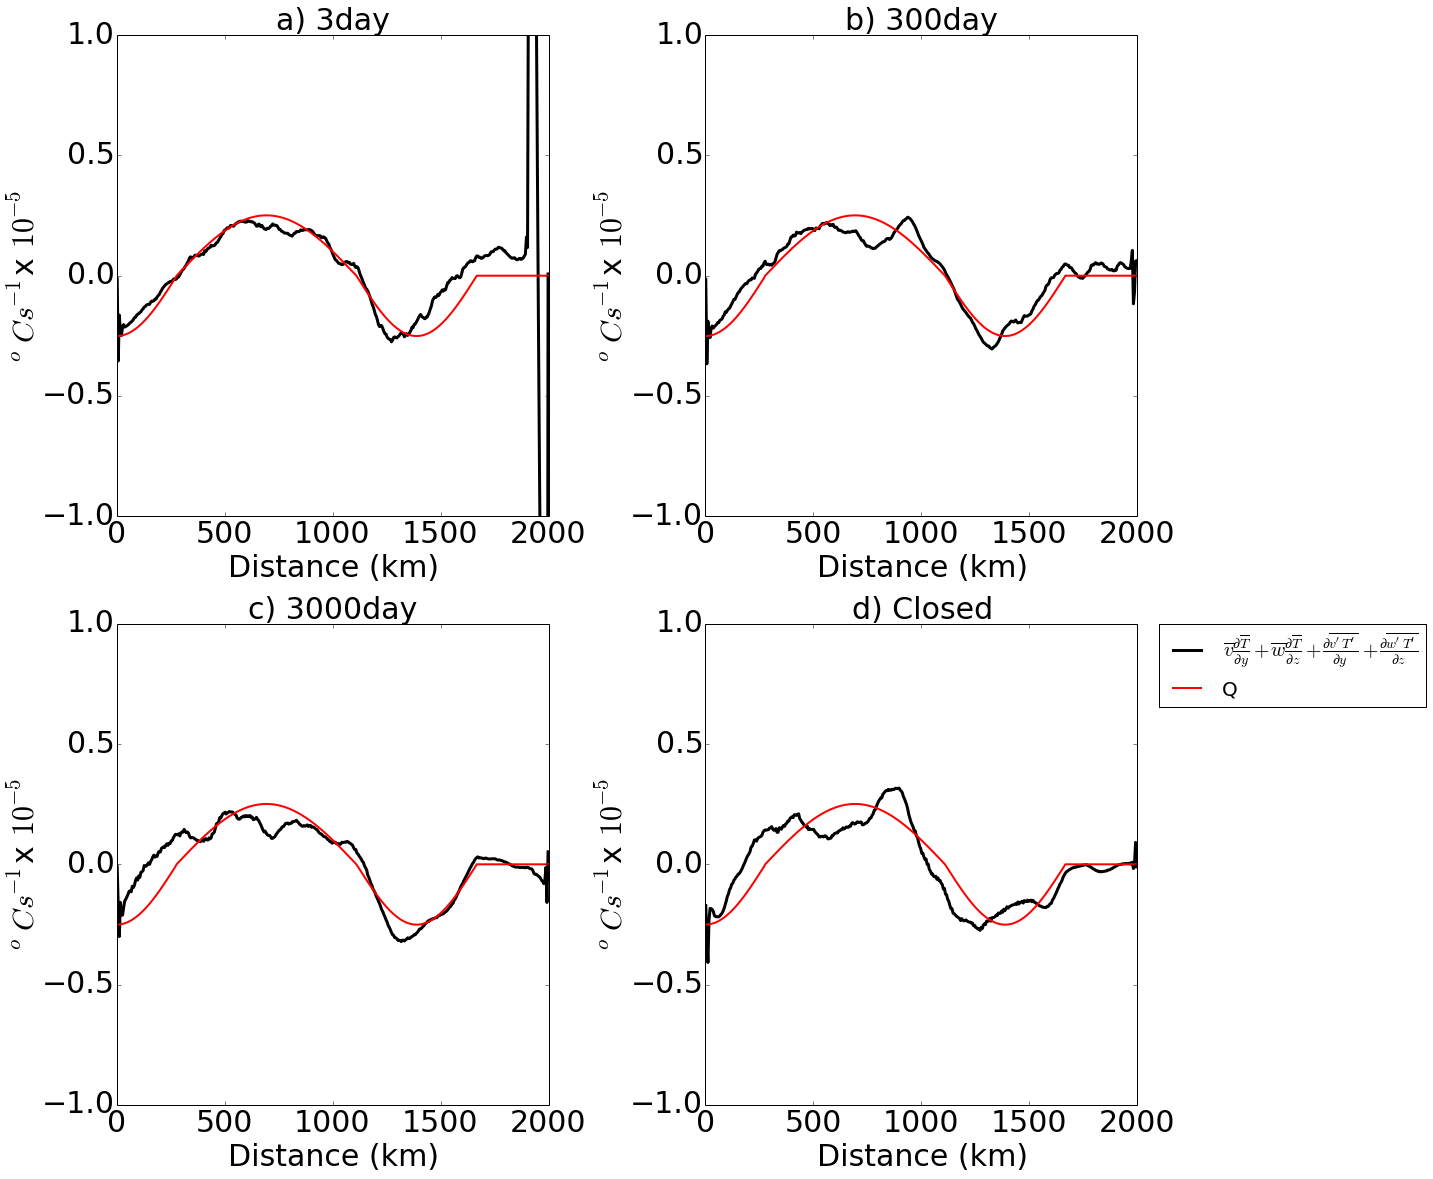

In [5]:
fig = plt.figure(figsize=(16.5, 16.5))
for i in range(len(Runs)):
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/TAV.nc'
    file2 = netCDF4.Dataset(fname, 'r')
    TTav = file2.variables['THETA'][:].mean(axis=0).mean(axis=2)
    VTav = file2.variables['VVEL'][:].mean(axis=0).mean(axis=2)
    WTav = file2.variables['WVEL'][:].mean(axis=0).mean(axis=2)
    npad =((0,1),(0,0))
    WTav = np.pad(WTav,pad_width=npad, mode='constant', constant_values=0)
    ax = fig.add_subplot(2, 2, i+1)
    Eddy1 = x+'/'+str(tau[Runs[i]])+'daynokpp/TAV_VT.nc'
    f2 = netCDF4.Dataset(Eddy1,'r')
    VTTav = f2.variables['VVELTH'][:].mean(axis=0).mean(axis=2)
    WTTav = f2.variables['WVELTH'][:].mean(axis=0).mean(axis=2)
    WTTav = np.pad(WTTav,pad_width=npad, mode='constant', constant_values=0)
    VpTp = hb.numba_regridy(VTTav) - hb.numba_regridy(VTav)*TTav
    WpTp = hb.numba_regridz(WTTav) - hb.numba_regridz(WTav)*TTav
    Ty = ddy_cgrid_centered(TTav)
    Tz = ddz_cgrid_centered(TTav)
    VTy = hb.numba_regridy(VTav)*Ty
    WTz = hb.numba_regridz(WTav)*Tz
    WpTpz = ddz_cgrid_centered(WpTp)
    VpTpy = ddy_cgrid_centered(VpTp)
    Diff = np.nansum((VTy+WTz+WpTpz+VpTpy)*Zmatrix,axis=0)
    p = plt.plot(Yc/1000,np.nansum((VTy+WTz+WpTpz+VpTpy)*Zmatrix,axis=0)*10**5,'k',linewidth=3)
    p = plt.plot(Yc/1000,Psipred*10**5,'r',linewidth=2)
    plt.ylim(-1,1)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel(r'$^oCs^{-1}$x $10^{-5}$', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
lgd=plt.legend([r'$\overline{v}\frac{\partial \overline{T}}{\partial y} + \overline{w}\frac{\partial \overline{T}}{\partial z} + \frac{\partial \overline{v^\prime T^\prime}}{\partial y} + \frac{\partial \overline{w^\prime T^\prime}}{\partial z}$','Q'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)
plt.tight_layout()

\begin{equation}
    \int_{-H}^{0} \frac{\partial \Psi _{res}}{\partial y}\frac{\partial \overline{T}}{\partial z} + \frac{\partial \Psi _{res}}{\partial z}\frac{\partial \overline{T}}{\partial y} \mathrm{d}z = \frac{Q}{C_p \rho_0} + \int_{-H}^{0} \frac{\partial \overline{v'T'}-\frac{w'T'}{Sp}}{\partial y } \mathrm{d}z
\end{equation}

/noc/users/hb1g13/.conda/envs/my_anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:121: RuntimeWarning: divide by zero encountered in divide


ValueError: x and y must have same first dimension

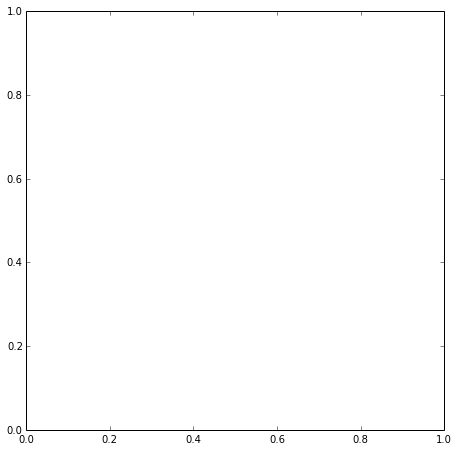

In [7]:
fig = plt.figure(figsize=(16.5, 16.5))
for i in range(len(Runs)):
    ax = fig.add_subplot(2, 2, i+1)
    
    # Psi_res(y,z)
    
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'+Year
    file2read = netCDF4.Dataset(fname, 'r')
    lvrho = file2read.variables["LaVH1TH"][:]
    th = file2read.variables["LaHs1TH"][:].mean(axis=3).mean(axis=0)
    dx = Y[1]-Y[0]  # Find Resolution
    VT = np.mean(lvrho, axis=3)  # Zonal average
    VTfdz = np.cumsum(VT[:, ::-1, :], axis=1)  # sum up the water column
    VTfdz = VTfdz
    # Time average and put into Sv and put back in right order
    psi = np.mean(VTfdz[:, ::-1, :], axis=0)
    psiz = hb.numba_regridz(hb.numba_regridy(get_psi_iso_z(psi, th)))
       
    # Temp field
    
    Rho = np.genfromtxt(x+'/'+str(tau[Runs[i]])+'daynokpp/Temp', delimiter=',')
    nolayers = len(psi[:, 1])
    Rho = Rho[0:nolayers]  # The layers package bins a layer so adjust
    Rho_matrix = np.apply_along_axis(np.multiply,0,ones_like(psi),Rho)
    T = hb.numba_regridz(hb.numba_regridy(get_psi_iso_z(Rho_matrix, th)))
    
    
    # Mean Stream Function:
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/TAV.nc'
    file2 = netCDF4.Dataset(fname, 'r')
    TTav = file2.variables['THETA'][:].mean(axis=0).mean(axis=2)
    VTav = file2.variables['VVEL'][:].mean(axis=0).mean(axis=2)
    WTav = file2.variables['WVEL'][:].mean(axis=0).mean(axis=2)
    npad =((0,1),(0,0))
    WTav = np.pad(WTav,pad_width=npad, mode='constant', constant_values=0)
    ax = fig.add_subplot(2, 2, i+1)
    Eddy1 = x+'/'+str(tau[Runs[i]])+'daynokpp/TAV_VT.nc'
    f2 = netCDF4.Dataset(Eddy1,'r')
    VTTav = f2.variables['VVELTH'][:].mean(axis=0).mean(axis=2)
    WTTav = f2.variables['WVELTH'][:].mean(axis=0).mean(axis=2)
    WTTav = np.pad(WTTav,pad_width=npad, mode='constant', constant_values=0)
    VpTp = hb.numba_regridy(VTTav) - hb.numba_regridy(VTav)*TTav
    WpTp = hb.numba_regridz(WTTav) - hb.numba_regridz(WTav)*TTav
    Ty = ddy_cgrid_centered(TTav)
    Tz = ddz_cgrid_centered(TTav)
    VTy = hb.numba_regridy(VTav)*Ty
    WTz = hb.numba_regridz(WTav)*Tz
    WpTpz = ddz_cgrid_centered(WpTp)
    VpTpy = ddy_cgrid_centered(VpTp)
    Ty = ddy_cgrid_centered(TTav)
    Tz = ddz_cgrid_centered(TTav)
    VTy = hb.numba_regridy(VTav)*Ty
    WTz = hb.numba_regridz(WTav)*Tz
    WpTpz = ddz_cgrid_centered(WpTp)
    VpTpy = ddy_cgrid_centered(VpTp)
    Diff = np.nansum((VTy+WTz+WpTpz+VpTpy)*Zmatrix,axis=0)-Psipred
    
    Tavlat = TTav
    V = file2.variables["VVEL"][:]
    Vtave = np.mean(V, axis=0)
    Vtave[Vtave == 0] = np.nan
    Vzone = np.mean(Vtave, axis=2)
    # Got rid of for loop here (much quicker!!)
    psi2 = np.apply_along_axis(np.multiply, 0, Vzone, dz)
    psi = np.cumsum(-psi2[::-1, :], axis=0)
    npad = ((0, 1), (0, 0))
    # Pad with zeros at bottom
    psi = np.pad(psi, pad_width=npad, mode='constant',
                 constant_values=0)
    
    Psied = psiz - hb.numba_regridz(hb.numba_regridy(psi))
    

    # Depth?
    zz = 30 # Full
    
    # There's a little noise, don't let it add up
    # psiz[np.round(psiz,3)==0] = np.nan
    # int PyTz + PzTy dz
    Py = ddy_cgrid_centered(psiz)
    Pz = ddz_cgrid_centered(psiz)
    # Get rid of essentially 0
    Py[abs(np.round(psiz,2))+np.max(psiz)/5<=0.05] = 0
    Pz[abs(np.round(psiz,2))+np.max(psiz)/5<=0.05] = 0
    Py[isnan(psiz)] = 0
    Pz[isnan(psiz)] = 0
    # Use layers field
    Ty_l = ddy_cgrid_centered(T)
    Tz_l = ddz_cgrid_centered(T)
    Ty_l[isnan(Ty_l)] = 0
    Tz_l[isnan(Tz_l)] = 0
    ROC = np.nansum(((Py*Tz_l+Pz*Ty_l)*Zmatrix)[0:zz,:],axis=0)
    
    # int dB/dZ dz = Q
    
    Q = Psipred
    
    # Diabatic Eddy Flux
    # int dVT/dy - d(WT/Sp)/dy dz
    # Careful there are some crazy numbers appearing 
    # REMOVE NANS AND INFS
    
   
    Ty[Ty<np.mean(Ty)/10] = np.mean(Ty)/10
    Tz[Tz<np.mean(Tz)/10] = np.mean(Tz)/10
    Sp = -Ty/Tz
    Sp[isinf(Sp)]=0
    Sp[isnan(Sp)]=0
    AD = ddz_cgrid_centered(Psied)*Ty_l # Adiabatic eddies
    
    AD[isinf(AD)]=0
    AD[isnan(AD)]=0
    
    WTSpdy = ddy_cgrid_centered(AD)
    D = (VpTpy-AD)*Zmatrix
    
    # Psied * Ty_l = W'T'
    
    WT = -Psied * Ty
    VT = Psied * Tz_l
    Sp_l = -Ty_l/Tz_l
    lvl = np.arange(-0.3,0.3,0.03)/50
    AD = WT/Sp
    #D = ddy_cgrid_centered(VpTp-WT/Sp) 
    
    D[8::] = 0
    
    D = -np.nansum((D*Zmatrix)[0:zz,0:400],axis =0)
    p = plt.plot(Z/1000,SG.savitzky_golay(ROC*10**5,15,1),'k',linewidth=2)
    plt.ylim(-1,1)

    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel(r'$ Sv $', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()
lgd=plt.legend([r'$\Psi_{res}|$,T)','D','Q'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)

In [ ]:
fig = plt.figure(figsize=(16.5, 16.5))
for i in range(len(Runs)):
    ax = fig.add_subplot(2, 2, i+1)
    
    # Psi_res(y,z)
    
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'+Year
    file2read = netCDF4.Dataset(fname, 'r')
    lvrho = file2read.variables["LaVH1TH"][:]
    th = file2read.variables["LaHs1TH"][:].mean(axis=3).mean(axis=0)
    dx = Y[1]-Y[0]  # Find Resolution
    VT = np.mean(lvrho, axis=3)  # Zonal average
    VTfdz = np.cumsum(VT[:, ::-1, :], axis=1)  # sum up the water column
    VTfdz = VTfdz
    # Time average and put into Sv and put back in right order
    psi = np.mean(VTfdz[:, ::-1, :], axis=0)
    psiz = hb.numba_regridz(hb.numba_regridy(get_psi_iso_z(psi, th)))
       
    # Temp field
    
    Rho = np.genfromtxt(x+'/'+str(tau[Runs[i]])+'daynokpp/Temp', delimiter=',')
    nolayers = len(psi[:, 1])
    Rho = Rho[0:nolayers]  # The layers package bins a layer so adjust
    Rho_matrix = np.apply_along_axis(np.multiply,0,ones_like(psi),Rho)
    T = hb.numba_regridz(hb.numba_regridy(get_psi_iso_z(Rho_matrix, th)))
    
    
    # Mean Stream Function:
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/TAV.nc'
    file2 = netCDF4.Dataset(fname, 'r')
    TTav = file2.variables['THETA'][:].mean(axis=0).mean(axis=2)
    VTav = file2.variables['VVEL'][:].mean(axis=0).mean(axis=2)
    WTav = file2.variables['WVEL'][:].mean(axis=0).mean(axis=2)
    npad =((0,1),(0,0))
    WTav = np.pad(WTav,pad_width=npad, mode='constant', constant_values=0)
    ax = fig.add_subplot(2, 2, i+1)
    Eddy1 = x+'/'+str(tau[Runs[i]])+'daynokpp/TAV_VT.nc'
    f2 = netCDF4.Dataset(Eddy1,'r')
    VTTav = f2.variables['VVELTH'][:].mean(axis=0).mean(axis=2)
    WTTav = f2.variables['WVELTH'][:].mean(axis=0).mean(axis=2)
    WTTav = np.pad(WTTav,pad_width=npad, mode='constant', constant_values=0)
    VpTp = hb.numba_regridy(VTTav) - hb.numba_regridy(VTav)*TTav
    WpTp = hb.numba_regridz(WTTav) - hb.numba_regridz(WTav)*TTav
    Ty = ddy_cgrid_centered(TTav)
    Tz = ddz_cgrid_centered(TTav)
    VTy = hb.numba_regridy(VTav)*Ty
    WTz = hb.numba_regridz(WTav)*Tz
    WpTpz = ddz_cgrid_centered(WpTp)
    VpTpy = ddy_cgrid_centered(VpTp)
    Ty = ddy_cgrid_centered(TTav)
    Tz = ddz_cgrid_centered(TTav)
    VTy = hb.numba_regridy(VTav)*Ty
    WTz = hb.numba_regridz(WTav)*Tz
    WpTpz = ddz_cgrid_centered(WpTp)
    VpTpy = ddy_cgrid_centered(VpTp)
    Diff = np.nansum((VTy+WTz+WpTpz+VpTpy)*Zmatrix,axis=0)-Psipred
    
    Tavlat = TTav
    V = file2.variables["VVEL"][:]
    Vtave = np.mean(V, axis=0)
    Vtave[Vtave == 0] = np.nan
    Vzone = np.mean(Vtave, axis=2)
    # Got rid of for loop here (much quicker!!)
    psi2 = np.apply_along_axis(np.multiply, 0, Vzone, dz)
    psi = np.cumsum(-psi2[::-1, :], axis=0)
    npad = ((0, 1), (0, 0))
    # Pad with zeros at bottom
    psi = np.pad(psi, pad_width=npad, mode='constant',
                 constant_values=0)
    
    Psied = psiz - hb.numba_regridz(hb.numba_regridy(psi))
    

    # Depth?
    zz = 5 # Full
    
    # There's a little noise, don't let it add up
    # psiz[np.round(psiz,3)==0] = np.nan
    # int PyTz + PzTy dz
    Py = ddy_cgrid_centered(psiz)
    Pz = ddz_cgrid_centered(psiz)
    # Get rid of essentially 0
    Py[abs(np.round(psiz,2))+np.max(psiz)/5<=0.05] = 0
    Pz[abs(np.round(psiz,2))+np.max(psiz)/5<=0.05] = 0
    Py[isnan(psiz)] = 0
    Pz[isnan(psiz)] = 0
    # Use layers field
    Ty_l = ddy_cgrid_centered(T)
    Tz_l = ddz_cgrid_centered(T)
    Ty_l[isnan(Ty_l)] = 0
    Tz_l[isnan(Tz_l)] = 0
    ROC = psiz[3,:]
    # int dB/dZ dz = Q
    
    
    # Diabatic Eddy Flux
    # int dVT/dy - d(WT/Sp)/dy dz
    # Careful there are some crazy numbers appearing 
    # REMOVE NANS AND INFS
    
   
    Ty[Ty<10**-6] = 10**-6
    Tz[Tz<10**-6] = 10**-6
    Sp = -Ty/Tz
    Sp[isinf(Sp)]=0
    Sp[isnan(Sp)]=0
    AD = ddz_cgrid_centered(Psied)*Ty_l # Adiabatic eddies
    
    AD[isinf(AD)]=0
    AD[isnan(AD)]=0
    
    WTSpdy = ddy_cgrid_centered(AD)
    D = np.sum(((VpTpy-AD)*Zmatrix)[0:zz,:],axis=0)
    
    # Psied * Ty_l = W'T'
    
    WT = -Psied * Ty
    VT = Psied * Tz_l
    Sp_l = -Ty_l/Tz_l
    lvl = np.arange(-0.3,0.3,0.03)/50
    AD = WT/Sp
    D = ddy_cgrid_centered(VpTp-WT/Sp)/(Ty[0,:])
    
    D[8::] = 0
    
    Q = Psipred/Ty[0,:]
    
    D = -np.nansum((D*Zmatrix)[0:zz,0:400],axis =0)
    p = plt.plot(Yc/1000,SG.savitzky_golay(ROC,15,1),'k',linewidth=2)
    p = plt.plot(Yc/1000,SG.savitzky_golay(D,15,1),'b',linewidth=2)
    p = plt.plot(Yc/1000,Q,'r',linewidth=2)
    p = plt.plot(Yc/1000,SG.savitzky_golay(ROC-Q,15,1),'b',linewidth=1)
    plt.ylim(-3.5,3)

    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel(r'$Sv$', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()
lgd=plt.legend([r'$\psi_{res}|_{hml}$','D','Q'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)

In [ ]:
fig = plt.figure(figsize=(16.5, 16.5))
for i in range(len(Runs)):
    ax = fig.add_subplot(2, 2, i+1)
    
    # Psi_res(y,z)
    
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'+Year
    file2read = netCDF4.Dataset(fname, 'r')
    lvrho = file2read.variables["LaVH1TH"][:]
    th = file2read.variables["LaHs1TH"][:].mean(axis=3).mean(axis=0)
    dx = Y[1]-Y[0]  # Find Resolution
    VT = np.mean(lvrho, axis=3)  # Zonal average
    VTfdz = np.cumsum(VT[:, ::-1, :], axis=1)  # sum up the water column
    VTfdz = VTfdz
    # Time average and put into Sv and put back in right order
    psi = np.mean(VTfdz[:, ::-1, :], axis=0)
    psiz = hb.numba_regridz(hb.numba_regridy(get_psi_iso_z(psi, th)))
       
    # Temp field
    
    Rho = np.genfromtxt(x+'/'+str(tau[Runs[i]])+'daynokpp/Temp', delimiter=',')
    nolayers = len(psi[:, 1])
    Rho = Rho[0:nolayers]  # The layers package bins a layer so adjust
    Rho_matrix = np.apply_along_axis(np.multiply,0,ones_like(psi),Rho)
    T = hb.numba_regridz(hb.numba_regridy(get_psi_iso_z(Rho_matrix, th)))
    
    
    # Mean Stream Function:
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/TAV.nc'
    file2 = netCDF4.Dataset(fname, 'r')
    TTav = file2.variables['THETA'][:].mean(axis=0).mean(axis=2)
    VTav = file2.variables['VVEL'][:].mean(axis=0).mean(axis=2)
    WTav = file2.variables['WVEL'][:].mean(axis=0).mean(axis=2)
    npad =((0,1),(0,0))
    WTav = np.pad(WTav,pad_width=npad, mode='constant', constant_values=0)
    ax = fig.add_subplot(2, 2, i+1)
    Eddy1 = x+'/'+str(tau[Runs[i]])+'daynokpp/TAV_VT.nc'
    f2 = netCDF4.Dataset(Eddy1,'r')
    VTTav = f2.variables['VVELTH'][:].mean(axis=0).mean(axis=2)
    WTTav = f2.variables['WVELTH'][:].mean(axis=0).mean(axis=2)
    WTTav = np.pad(WTTav,pad_width=npad, mode='constant', constant_values=0)
    VpTp = hb.numba_regridy(VTTav) - hb.numba_regridy(VTav)*TTav
    WpTp = hb.numba_regridz(WTTav) - hb.numba_regridz(WTav)*TTav
    Ty = ddy_cgrid_centered(TTav)
    Tz = ddz_cgrid_centered(TTav)
    VTy = hb.numba_regridy(VTav)*Ty
    WTz = hb.numba_regridz(WTav)*Tz
    WpTpz = ddz_cgrid_centered(WpTp)
    VpTpy = ddy_cgrid_centered(VpTp)
    Ty = ddy_cgrid_centered(TTav)
    Tz = ddz_cgrid_centered(TTav)
    VTy = hb.numba_regridy(VTav)*Ty
    WTz = hb.numba_regridz(WTav)*Tz
    WpTpz = ddz_cgrid_centered(WpTp)
    VpTpy = ddy_cgrid_centered(VpTp)
    Diff = np.nansum((VTy+WTz+WpTpz+VpTpy)*Zmatrix,axis=0)-Psipred
    
    Tavlat = TTav
    V = file2.variables["VVEL"][:]
    Vtave = np.mean(V, axis=0)
    Vtave[Vtave == 0] = np.nan
    Vzone = np.mean(Vtave, axis=2)
    # Got rid of for loop here (much quicker!!)
    psi2 = np.apply_along_axis(np.multiply, 0, Vzone, dz)
    psi = np.cumsum(-psi2[::-1, :], axis=0)
    npad = ((0, 1), (0, 0))
    # Pad with zeros at bottom
    psi = np.pad(psi, pad_width=npad, mode='constant',
                 constant_values=0)
    
    Psied = psiz - hb.numba_regridz(hb.numba_regridy(psi))
    

    # Depth?
    zz = 5 # Full
    
    # There's a little noise, don't let it add up
    # psiz[np.round(psiz,3)==0] = np.nan
    # int PyTz + PzTy dz
    Py = ddy_cgrid_centered(psiz)
    Pz = ddz_cgrid_centered(psiz)
    # Get rid of essentially 0
    Py[abs(np.round(psiz,2))+np.max(psiz)/5<=0.05] = 0
    Pz[abs(np.round(psiz,2))+np.max(psiz)/5<=0.05] = 0
    Py[isnan(psiz)] = 0
    Pz[isnan(psiz)] = 0
    # Use layers field
    Ty_l = ddy_cgrid_centered(T)
    Tz_l = ddz_cgrid_centered(T)
    Ty_l[isnan(Ty_l)] = 0
    Tz_l[isnan(Tz_l)] = 0
    ROC = psiz[3,:]*Ty[0,:]
    # int dB/dZ dz = Q
    
    
    # Diabatic Eddy Flux
    # int dVT/dy - d(WT/Sp)/dy dz
    # Careful there are some crazy numbers appearing 
    # REMOVE NANS AND INFS
    
   
    Ty[Ty<10**-6] = 10**-6
    Tz[Tz<10**-6] = 10**-6
    Sp = -Ty/Tz
    Sp[isinf(Sp)]=0
    Sp[isnan(Sp)]=0
    AD = ddz_cgrid_centered(Psied)*Ty_l # Adiabatic eddies
    
    AD[isinf(AD)]=0
    AD[isnan(AD)]=0
    
    WTSpdy = ddy_cgrid_centered(AD)
    D = np.sum(((VpTpy-AD)*Zmatrix)[0:zz,:],axis=0)
    
    # Psied * Ty_l = W'T'
    
    WT = -Psied * Ty
    VT = Psied * Tz_l
    Sp_l = -Ty_l/Tz_l
    lvl = np.arange(-0.3,0.3,0.03)/50
    AD = WT/Sp
    D = ddy_cgrid_centered(VpTp-WT/Sp)
    
    D[8::] = 0
    
    Q = Psipred
    
    D = -np.nansum((D*Zmatrix)[0:zz,0:400],axis =0)
    p = plt.plot(Yc/1000,SG.savitzky_golay(ROC*10**5,15,1),'k',linewidth=2)
    p = plt.plot(Yc/1000,SG.savitzky_golay(D*10**5,15,1),'b',linewidth=2)
    p = plt.plot(Yc/1000,Q*10**5,'r',linewidth=2)
    p = plt.plot(Yc/1000,SG.savitzky_golay((ROC-Q)*10**5,15,1),'b',linewidth=1)
    plt.ylim(-1,1)

    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel(r'$^oC m^2 s^{-1} $', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()
lgd=plt.legend([r'$\psi_{res}|_{hml}$','D','Q'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)

/noc/users/hb1g13/.conda/envs/my_anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:118: RuntimeWarning: divide by zero encountered in divide
/noc/users/hb1g13/.conda/envs/my_anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:514: FutureWarning: In Numpy 1.9 the sum along empty slices will be zero.
  FutureWarning)
/noc/users/hb1g13/.conda/envs/my_anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:118: RuntimeWarning: invalid value encountered in divide


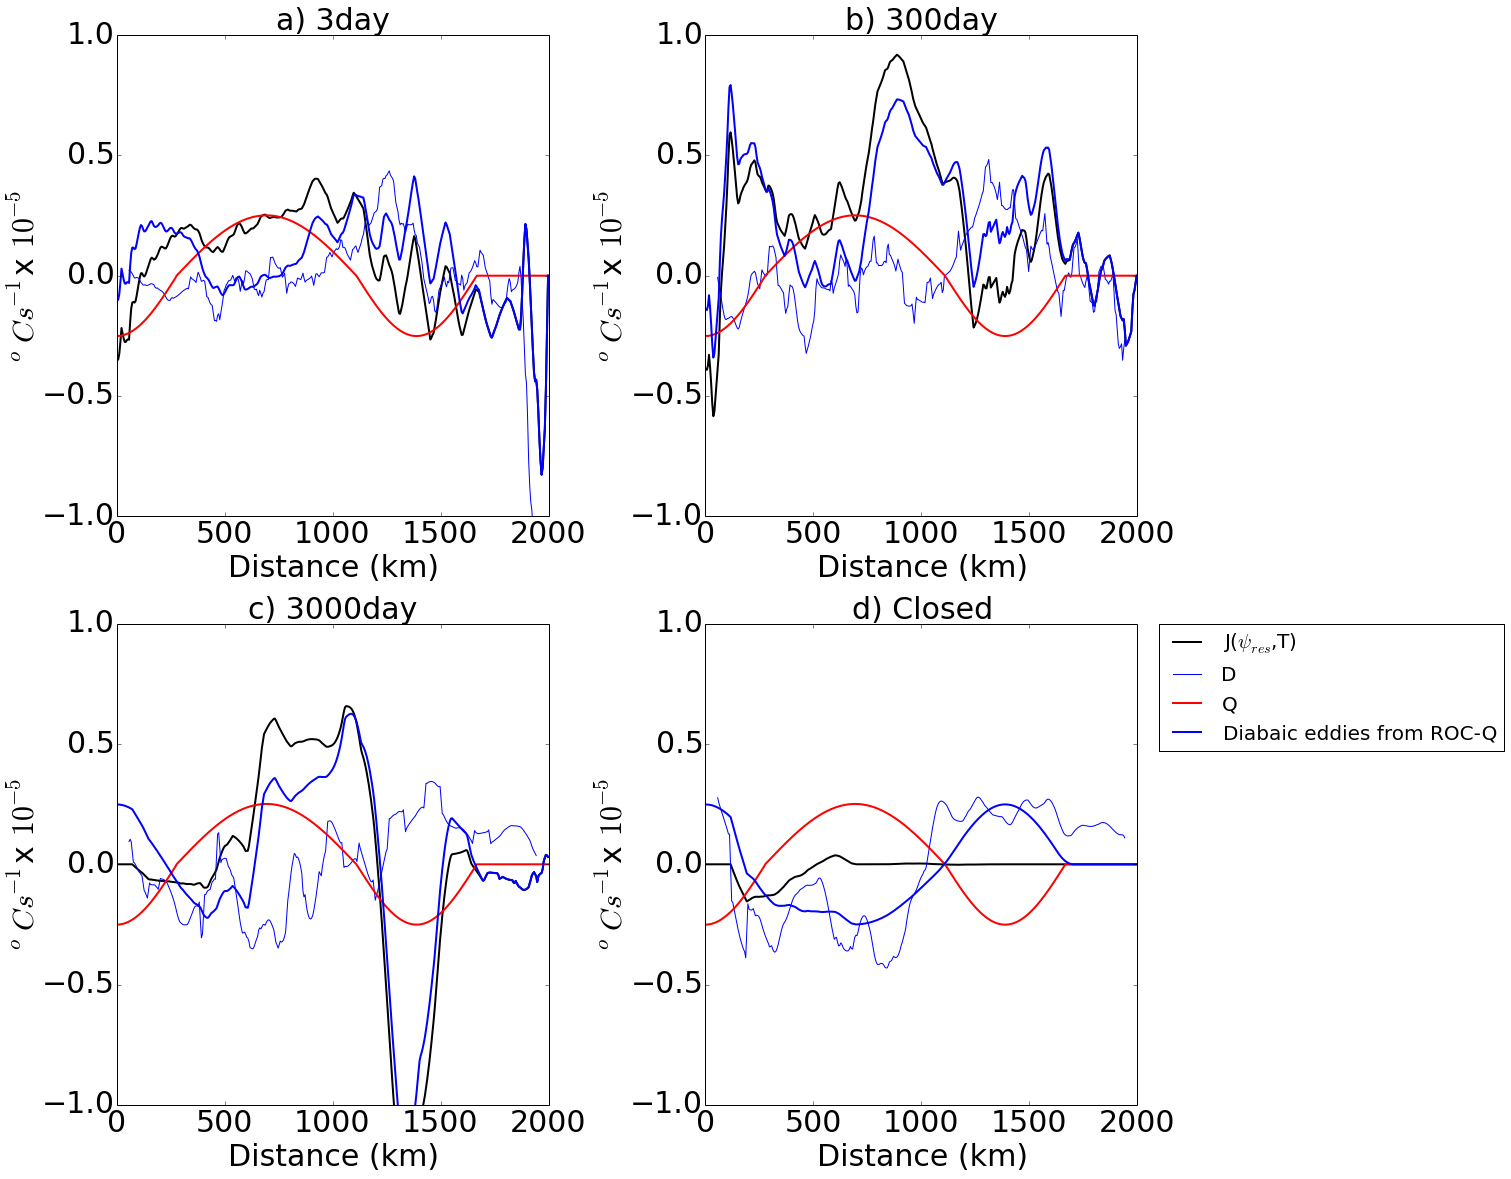

In [8]:
fig = plt.figure(figsize=(16.5, 16.5))
for i in range(len(Runs)):
    ax = fig.add_subplot(2, 2, i+1)
    
    # Psi_res(y,z)
    
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'+Year
    file2read = netCDF4.Dataset(fname, 'r')
    lvrho = file2read.variables["LaVH1TH"][:]
    th = file2read.variables["LaHs1TH"][:].mean(axis=3).mean(axis=0)
    dx = Y[1]-Y[0]  # Find Resolution
    VT = np.mean(lvrho, axis=3)  # Zonal average
    VTfdz = np.cumsum(VT[:, ::-1, :], axis=1)  # sum up the water column
    VTfdz = VTfdz
    # Time average and put into Sv and put back in right order
    psi = np.mean(VTfdz[:, ::-1, :], axis=0)
    psiz = hb.numba_regridz(hb.numba_regridy(get_psi_iso_z(psi, th)))
       
    # Temp field
    
    Rho = np.genfromtxt(x+'/'+str(tau[Runs[i]])+'daynokpp/Temp', delimiter=',')
    nolayers = len(psi[:, 1])
    Rho = Rho[0:nolayers]  # The layers package bins a layer so adjust
    Rho_matrix = np.apply_along_axis(np.multiply,0,ones_like(psi),Rho)
    T = hb.numba_regridz(hb.numba_regridy(get_psi_iso_z(Rho_matrix, th)))
    
    
    # Mean Stream Function:
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/TAV.nc'
    file2 = netCDF4.Dataset(fname, 'r')
    TTav = file2.variables['THETA'][:].mean(axis=0).mean(axis=2)
    VTav = file2.variables['VVEL'][:].mean(axis=0).mean(axis=2)
    WTav = file2.variables['WVEL'][:].mean(axis=0).mean(axis=2)
    npad =((0,1),(0,0))
    WTav = np.pad(WTav,pad_width=npad, mode='constant', constant_values=0)
    ax = fig.add_subplot(2, 2, i+1)
    Eddy1 = x+'/'+str(tau[Runs[i]])+'daynokpp/TAV_VT.nc'
    f2 = netCDF4.Dataset(Eddy1,'r')
    VTTav = f2.variables['VVELTH'][:].mean(axis=0).mean(axis=2)
    WTTav = f2.variables['WVELTH'][:].mean(axis=0).mean(axis=2)
    WTTav = np.pad(WTTav,pad_width=npad, mode='constant', constant_values=0)
    VpTp = hb.numba_regridy(VTTav) - hb.numba_regridy(VTav)*TTav
    WpTp = hb.numba_regridz(WTTav) - hb.numba_regridz(WTav)*TTav
    Ty = ddy_cgrid_centered(TTav)
    Tz = ddz_cgrid_centered(TTav)
    VTy = hb.numba_regridy(VTav)*Ty
    WTz = hb.numba_regridz(WTav)*Tz
    WpTpz = ddz_cgrid_centered(WpTp)
    VpTpy = ddy_cgrid_centered(VpTp)
    
    
    Tavlat = TTav
    V = file2.variables["VVEL"][:]
    Vtave = np.mean(V, axis=0)
    Vtave[Vtave == 0] = np.nan
    Vzone = np.mean(Vtave, axis=2)
    # Got rid of for loop here (much quicker!!)
    psi2 = np.apply_along_axis(np.multiply, 0, Vzone, dz)
    psi = np.cumsum(-psi2[::-1, :], axis=0)
    npad = ((0, 1), (0, 0))
    # Pad with zeros at bottom
    psi = np.pad(psi, pad_width=npad, mode='constant',
                 constant_values=0)
    
    Psied = psiz - hb.numba_regridz(hb.numba_regridy(psi))
    

    # Depth?
    zz = 30 # Full
    
    # There's a little noise, don't let it add up
    # psiz[np.round(psiz,3)==0] = np.nan
    # int PyTz + PzTy dz
    Py = ddy_cgrid_centered(psiz)
    Pz = ddz_cgrid_centered(psiz)
    # Get rid of essentially 0
    Py[abs(np.round(psiz,2))<=0.1] = 0
    Pz[abs(np.round(psiz,2))<=0.1] = 0
    #Py[abs(np.round(psiz,2))+np.max(psiz)/5<=0.1] = 0
    #Pz[abs(np.round(psiz,2))+np.max(psiz)/5<=0.1] = 0
    Py[isnan(psiz)] = 0
    Pz[isnan(psiz)] = 0
    # Use layers field
    Ty_l = ddy_cgrid_centered(T)
    Tz_l = ddz_cgrid_centered(T)
    Ty_l[isnan(Ty_l)] = 0
    Tz_l[isnan(Tz_l)] = 0
    ROC = np.nansum(((Py*Tz_l+Pz*Ty_l)*Zmatrix)[0:zz,:],axis=0)
    
    # int dB/dZ dz = Q
    
    Q = Psipred
    
    # Diabatic Eddy Flux
    # int dVT/dy - d(WT/Sp)/dy dz
    # Careful there are some crazy numbers appearing 
    # REMOVE NANS AND INFS
    
   
    Ty[Ty<np.mean(Ty)/10] = np.mean(Ty)/10
    Tz[Tz<np.mean(Tz)/10] = np.mean(Tz)/10
    Sp = -Ty/Tz
    Sp[isinf(Sp)]=0
    Sp[isnan(Sp)]=0
    AD = ddz_cgrid_centered(Psied)*Ty_l # Adiabatic eddies
    
    AD[isinf(AD)]=0
    AD[isnan(AD)]=0
    
    WTSpdy = ddy_cgrid_centered(AD)
    D = np.sum(((VpTpy-AD)*Zmatrix)[0:zz,:],axis=0)
    
    # Psied * Ty_l = W'T'
    psiz[abs(np.round(psiz,2))<=0.1] = 0
    Psied = psiz - hb.numba_regridz(hb.numba_regridy(psi))
    WT = -Psied * Ty
    VT = Psied * Tz_l
    Sp_l = -Ty_l/Tz_l
    lvl = np.arange(-0.3,0.3,0.03)/50
    AD = WT/Sp
    D = ddy_cgrid_centered(VpTp-WT/Sp)
    #D[8::] = 0
    
    D = -np.nansum((D*Zmatrix)[0:zz,0:400],axis =0)
    p = plt.plot(Yc/1000,SG.savitzky_golay(ROC,15,1)*10**5,'k',linewidth=2)
    p = plt.plot(Yc/1000,SG.savitzky_golay(D,15,1)*10**5,'b',linewidth=1)
    p = plt.plot(Yc/1000,Q*10**5,'r',linewidth=2)
    p = plt.plot(Yc/1000,SG.savitzky_golay(ROC-Q,15,1)*10**5,'b',linewidth=2)
    plt.ylim(-1,1)

    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel(r'$^oCs^{-1}$x $10^{-5}$', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()
lgd=plt.legend([r'J($\psi_{res}$,T)','D','Q','Diabaic eddies from ROC-Q'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)

Stream functions only!!

\begin{equation}
    \int_{-H}^{0} 
    \left( \frac{\partial \overline{\Psi}}{\partial y} + \frac{\partial \Psi^*}{\partial y} \right)
    \frac{\partial  \overline{T}}{\partial z} + 
    \left( \frac{\partial \overline{\Psi}}{\partial z} + \frac{\partial \Psi^*}{\partial z}  \right)
    \frac{\partial \overline{T}}{\partial y} \mathrm{d}z = \frac{Q}{C_p \rho_0} + \int_{-H}^{0} \frac{\partial \overline{v'T'}-\frac{w'T'}{Sp}}{\partial y } \mathrm{d}z
\end{equation}

With out any fileting D is VERY NOISY...

Options:

* Implicit Diabatic eddies
* Smooth data with simple filter or take gradients with larger window
* Diagnose alternative way
* Go back to Mean Bouyancy Budget Equation

First Plot D to see where it's so noisy:

\begin{equation}
\underbrace{\overline{v}  \frac{\partial \overline{T}}{\partial y } + \frac{\partial (\overline{T_z} \overline{w'T' /\overline{T_y}})}{\partial y} + \overline{w}\frac{\partial \overline{T}}{\partial z } +  \frac{\partial \overline{w'T'}}{\partial z }}_\text{ROC avective terms} = \underbrace{\frac{\partial B}{\partial z}}_\text{Air-sea fluxes} - \underbrace{\frac{\partial \overline{v'T'}-\frac{w'T'}{Sp}}{\partial y }}_\text{Diabatic eddies} 
\end{equation}

This is matematicall sound, but does the LHS really show the ROC well ?

Check Eddy heat fluxes:

1$^{st}$ break down = simple mean and eddy components

$v\,=\, \overline{v}+v'$

$T\,=\,\overline{T}+T'$

Total Heat Flux: $C_p\,\rho \, \iint \overline{vT}\, dxdz$

Mean Heat Flux= $C_p\,\rho \, \iint \overline{v}\overline{T}\, dxdz$

Eddy Heat Flux= $C_p\,\rho \, \iint \overline{v'T'}\, dxdz$

And vertical:

$w\,=\, \overline{w}+w'$

$T\,=\,\overline{T}+T'$

Total Heat Flux: $C_p\,\rho \, \iint \overline{wT}\, dxdy$

Mean Heat Flux= $C_p\,\rho \, \iint \overline{w}\overline{T}\, dxdy$

Eddy Heat Flux= $C_p\,\rho \, \iint \overline{w'T'}\, dxdy$


Diff in Mean + Eddy and totol = 0.0225876628963
Diff in Mean + Eddy and totol = 1.06777903782


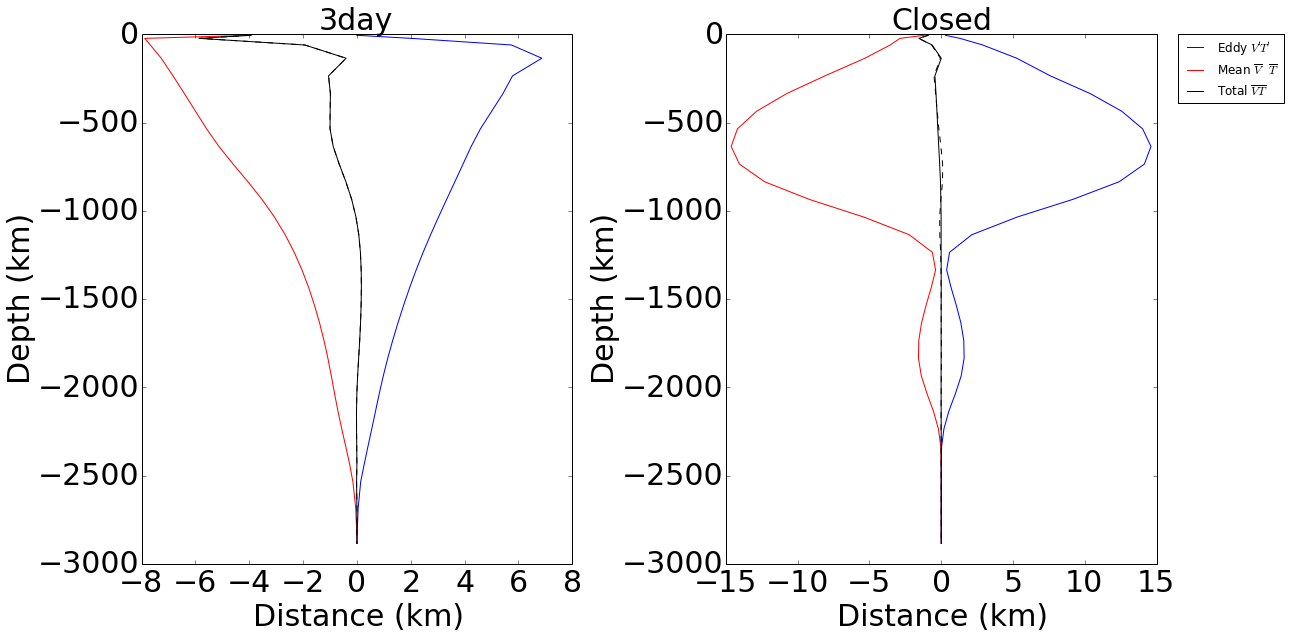

In [217]:
fig = plt.figure(figsize=(16.5, 16.5))
for i in range(len(Runs)):
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/WTprimebar.nc'
    file2read = netCDF4.Dataset(fname, 'r')
    WT = file2read.variables['WT']
    WTzone = np.mean(WT[:]*1, axis=2)
    WTdAed = WTzone
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/WTbar.nc'
    file2read = netCDF4.Dataset(fname, 'r')
    WT = file2read.variables['WT']
    WTzone = np.mean(WT[:]*1, axis=2)
    WTdAtot = WTzone
    filename = x+'/'+str(tau[Runs[i]])+'daynokpp/Tav.nc'
    file2read = netCDF4.Dataset(filename, 'r')
    Temp = file2read.variables["THETA"][:]
    filename = x+'/'+str(tau[Runs[i]])+'daynokpp/WTav.nc'
    file2read = netCDF4.Dataset(filename, 'r')
    Wtav = file2read.variables["WVEL"][:]
    npad =((0,0),(0,1),(0,0),(0,0))
    Wtav = np.pad(Wtav,pad_width=npad, mode='constant', constant_values=0)
    Tzone = np.mean(np.mean(Temp, axis=0), axis=2)
    Wzone = np.mean(np.mean(Wtav, axis=0), axis=2)
    WT=hb.numba_regridz(Wzone)*Tzone
    WTdAmean=WT
    Tzone = np.mean(np.mean(Temp, axis=0), axis=2)
    Q2_levs = (np.arange(1, 8, 1))
    y = Yc/1000
    Q_levs = np.arange(-0.055, 0.055, 0.0025)
    Q_ticks = np.arange(-0.04, 0.04, 0.01)
    MeanHF=1030*3985*Lx*Lx*(np.sum(WTdAmean,axis=1))/10**15
    EddyHF=1030*3985*Lx*Lx*(np.sum(WTdAed,axis=1))/10**15
    TotalHF=1030*3985*Lx*Lx*(np.sum(WTdAtot,axis=1))/10**15
    THF=MeanHF+EddyHF
    ax = fig.add_subplot(2, 2, i+1)
    # VTzone[VTzone<-0.029]=-0.029
    E,=ax.plot(EddyHF,Z,'b')
    M,=ax.plot(MeanHF,Z,'r')
    T,=ax.plot(TotalHF,Z,'k')
    MEp,=ax.plot(THF,Z,'--k')
    print 'Diff in Mean + Eddy and totol = '+str(sum(abs(TotalHF-THF)))
    ax.set_title(str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(tau[Runs[i]]), fontsize=30)
    ax.set_ylabel("Heat Flux (PW)")
    ax.set_xlabel("Meridional Distance (km)")
    ax.set_title(str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel('Depth (km)', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()
lgd=legend([E,M,T],["Eddy $V'T'$","Mean $\overline{V}\,\,\overline{T}$",
                    "Total $\overline{VT}$",'MEAN+EDDY'],bbox_to_anchor=(1.05, 1),loc=2, borderaxespad=0.)

Diff in Mean + Eddy and totol = 0.00130657756461
Diff in Mean + Eddy and totol = 0.00349346939161
Diff in Mean + Eddy and totol = 0.00312469622748
Diff in Mean + Eddy and totol = 0.00658239679206


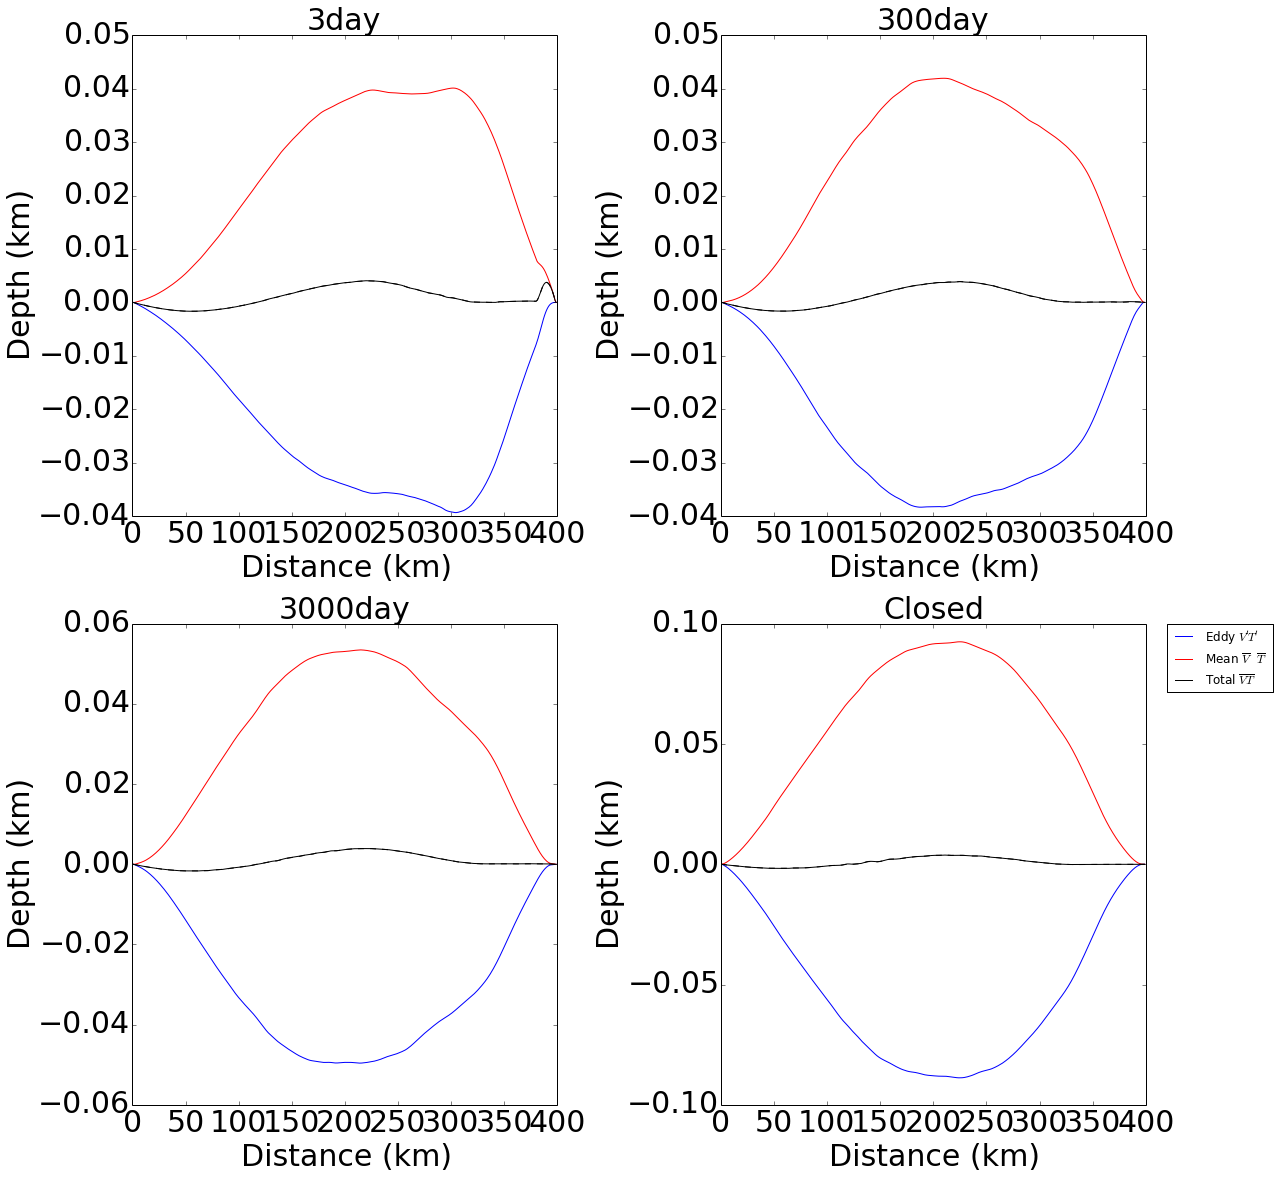

In [12]:
fig = plt.figure(figsize=(16.5, 16.5))
for i in range(len(Runs)):
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/VTprimebar.nc'
    file2read = netCDF4.Dataset(fname, 'r')
    VT = file2read.variables['VT']
    VTzone = np.mean(VT[:]*1, axis=2)
    VTdAed = Zmatrix*VTzone
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/VTbar.nc'
    file2read = netCDF4.Dataset(fname, 'r')
    VT = file2read.variables['VT']
    VTzone = np.mean(VT[:]*1, axis=2)
    VTdAtot = Zmatrix*VTzone
    filename = x+'/'+str(tau[Runs[i]])+'daynokpp/Tav.nc'
    file2read = netCDF4.Dataset(filename, 'r')
    Temp = file2read.variables["THETA"][:]
    Vtav = file2read.variables["VVEL"][:]
    Tzone = np.mean(np.mean(Temp, axis=0), axis=2)
    Vzone = np.mean(np.mean(Vtav, axis=0), axis=2)
    VT=hb.numba_regridy(Vzone)*Tzone
    VTdAmean=VT*Zmatrix
    Tzone = np.mean(np.mean(Temp, axis=0), axis=2)
    Q2_levs = (np.arange(1, 8, 1))
    y = Yc/1000
    Q_levs = np.arange(-0.055, 0.055, 0.0025)
    Q_ticks = np.arange(-0.04, 0.04, 0.01)
    MeanHF=1030*3985*Lx*(np.sum(VTdAmean,axis=0))/10**15
    EddyHF=1030*3985*Lx*(np.sum(VTdAed,axis=0))/10**15
    TotalHF=1030*3985*Lx*(np.sum(VTdAtot,axis=0))/10**15
    THF=MeanHF+EddyHF
    ax = fig.add_subplot(2, 2, i+1)
    # VTzone[VTzone<-0.029]=-0.029
    E,=ax.plot(EddyHF)
    M,=ax.plot(MeanHF,'r')
    T,=ax.plot(TotalHF,'k')
    MEp,=ax.plot(THF,'--k')
    print 'Diff in Mean + Eddy and totol = '+str(sum(abs(TotalHF-THF)))
    ax.set_title(str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(tau[Runs[i]]), fontsize=30)
    ax.set_ylabel("Heat Flux (PW)")
    ax.set_xlabel("Meridional Distance (km)")
    ax.set_title(str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel('Depth (km)', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()
lgd=legend([E,M,T],["Eddy $V'T'$","Mean $\overline{V}\,\,\overline{T}$",
                    "Total $\overline{VT}$",'Mean+Eddy'],bbox_to_anchor=(1.05, 1),loc=2, borderaxespad=0.)